In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import auc
from torch import optim
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import os
import pandas as pd
from PIL import Image
import csv
import random
from sklearn.utils.class_weight import compute_class_weight

# Load data

## List of file paths

In [ ]:
# Please change the following paths to corresponding paths in your folder
orig_data_path = "/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Augmented-ads-16_cleaned1.csv"
orig_processed_data_path = "/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/one_hot_user_features_complete.csv"
test_data_path = "/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Test Data User Info.csv"
caption_bert_path_old = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "caption_bert_768.data")
caption_bert_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "caption_1109_bert_128.data")
caption_bert_path_2 = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "caption_1109_bert_tuned_768.data")

score_data_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "user_scores_normalized.csv")
user_feature_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "one_hot_user_features_complete.csv")

img_embs_based_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "img_embs_base_512.data")
img_embs_tuned_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "img_embs_base_512.data")
img_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "ads_no_category")
aug_img_path = os.path.join('/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables/Final Data', "aug_imgs")


## Process test user information

In [ ]:
orig_df = pd.read_csv(orig_data_path)
orig_df_user_info = orig_df.iloc[:, np.r_[0:6,-10:-1]]
categories = {}
for col in orig_df_user_info.columns:
  if col.startswith("M"):
    orig_df_user_info[col] = [row.split(", ") for row in orig_df_user_info[col]]
    categories[col] = list(set([item for sublist in orig_df_user_info[col] for item in sublist]))
  elif col.startswith("J") or col.startswith("T"):
    categories[col] = list(set(orig_df_user_info[col].tolist()))
  elif col.startswith("H"):
    orig_df_user_info[col] = [row.split(", ")[-1] for row in orig_df_user_info[col]]
    categories[col] = list(set(orig_df_user_info[col]))
categories["Age"] = ['10','20','30','40','50','60']
test_df = pd.read_csv(test_data_path)
test_df["Age"] = test_df["Age"].div(10).apply(np.floor).mul(10).astype(int).astype(str)
og_col_cnt = 0
new_col_cnt = 0
one_hot_user_info = pd.DataFrame(test_df["UserID"])
orig_one_hot = pd.read_csv(orig_processed_data_path)
cnt = 0
for i in categories:
  if i.startswith("M"):
    og_col_cnt += 1
    # make each item in the category as columns of dataframe, initialize with 0
    # one_hot_user_info = one_hot_user_info.assign(**dict.fromkeys(categories_multi[i],0 ))
    for col in orig_one_hot.columns:
      if col.startswith("Feature "+str(cnt)+"_"):
        one_hot_user_info[col] = 0
        target = col.split("Feature "+str(cnt)+"_")[1]
        new_col_cnt += 1
        for k in range(len(test_df)):
          if (target in test_df[i][k]):
              one_hot_user_info.iloc[k,new_col_cnt] = 1
  else:
    og_col_cnt += 1
    for col in orig_one_hot.columns:
      if col.startswith("Feature "+str(cnt)+"_"):
        one_hot_user_info[col] = 0
        target = col.split("Feature "+str(cnt)+"_")[1]
        new_col_cnt += 1
        for k in range(len(test_df)):
          if (target == test_df[i][k]):
            one_hot_user_info.iloc[k,new_col_cnt] = 1
  cnt += 1
# Normalize BIG-5 personalities scores by dividing by a factor of 10
for col in orig_df_user_info.columns:
  if "score" in col:
    one_hot_user_info[col] = test_df[col][:]/10
# Drop UserID column
one_hot_user_info = one_hot_user_info.to_numpy()[:, 1:]

<ipython-input-85-e290c626e5b2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_df_user_info[col] = [row.split(", ") for row in orig_df_user_info[col]]
<ipython-input-85-e290c626e5b2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_df_user_info[col] = [row.split(", ")[-1] for row in orig_df_user_info[col]]
<ipython-input-85-e290c626e5b2>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

# Model Architectures



In [ ]:
class caption_only_mlp(nn.Module):
    def __init__(self, arg, input_dim) -> None:
        super(caption_only_mlp, self).__init__()
        hidden_dim = arg['hidden_dim']
        dropout = arg['dropout']
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.BatchNorm1d(num_features=hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.BatchNorm1d(num_features=hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.BatchNorm1d(num_features=hidden_dim[2]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.BatchNorm1d(num_features=hidden_dim[3]),
            nn.ReLU(),
            nn.Linear(hidden_dim[3], arg['output_dim'])
        )

    def forward(self, x):
        x = self.layer(x)
        return x

class model_caption_only(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(model_caption_only, self).__init__()
        self.image_cnn_mlp = late_fusion_cnn_mlp(arg, model_ft)
        if arg['caption_version'] == 'short':
            self.caption_mlp = late_fusion_mlp(arg, 141+128)
        elif arg['caption_version'] == 'long':
            self.caption_mlp = late_fusion_mlp(arg, 141+768)
        elif arg['caption_version'] == 'old':
            self.caption_mlp = late_fusion_mlp(arg, 141+768)
        elif arg['caption_version'] == 'image':
            self.caption_mlp = late_fusion_mlp(arg, 141+512)
        elif arg['caption_version'] == 'image_tuned':
            self.caption_mlp = late_fusion_mlp(arg, 141+512)

    def forward(self, data_dict):
        scores = self.caption_mlp(data_dict['caption_and_user_inputs'])
        return scores

class image_only_mlp(nn.Module):
    def __init__(self, arg, input_dim) -> None:
        super(image_only_mlp, self).__init__()
        hidden_dim = arg['hidden_dim']
        dropout = arg['dropout']
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.BatchNorm1d(num_features=hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.BatchNorm1d(num_features=hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.BatchNorm1d(num_features=hidden_dim[2]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.BatchNorm1d(num_features=hidden_dim[3]),
            nn.ReLU(),
            nn.Linear(hidden_dim[3], arg['output_dim'])
        )

    def forward(self, x):
        x = self.layer(x)
        return x

class image_only_cnn_mlp(nn.Module):
    def __init__(self, arg, model_ft, dropout=0.2) -> None:
        super(image_only_cnn_mlp, self).__init__()
        self.conv_layer = model_ft
        self.mlp = image_only_mlp(arg, 141+arg['img_embs_size'])

    def forward(self, user_embed, image):
        x = image
        x = self.conv_layer(x)
        user_image_embs = torch.cat((user_embed, x), 1)
        image_scores = self.mlp(user_image_embs)
        return image_scores

class model_image_only(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(model_image_only, self).__init__()
        self.image_cnn_mlp = image_only_cnn_mlp(arg, model_ft)

    def forward(self, data_dict):
        scores = self.image_cnn_mlp(data_dict['user_input'], data_dict['image_inputs'])
        return scores

class early_fusion_cnn_mlp(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(early_fusion_cnn_mlp, self).__init__()
        if arg['caption_version'] == 'short':
            input_dim = 2317
        elif arg['caption_version'] == 'long':
            input_dim = 2317-128+768
        output_dim = arg['output_dim']
        self.conv_layer = model_ft
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True))
        self.mlp = nn.Sequential(
            nn.Linear(32*7*7, 32*5*5),
            nn.BatchNorm1d(num_features=32*5*5),
            nn.ReLU(),
            nn.Linear(32*5*5, 32*3*3),
            nn.BatchNorm1d(num_features=32*3*3),
            nn.ReLU(),
            nn.Linear(32*3*3, 32*3*3),
            nn.BatchNorm1d(num_features=32*3*3),
            nn.ReLU(),
            nn.Linear(32*3*3, 32),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, caption_and_user, image):
        x = image
        x = self.conv_layer(x)
        x = torch.cat((x, caption_and_user.unsqueeze(-1).unsqueeze(-1).repeat(1,1,x.shape[-2], x.shape[-1])),dim=1)
        x = self.conv1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.mlp(x)
        return x

class model_early_fusion(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(model_early_fusion, self).__init__()
        self.image_cnn_mlp = early_fusion_cnn_mlp(arg, model_ft)

    def forward(self, data_dict):
        scores = self.image_cnn_mlp(data_dict['caption_and_user_inputs'], data_dict['image_inputs'])
        return scores

class late_fusion_mlp(nn.Module):
    def __init__(self, arg, input_dim) -> None:
        super(late_fusion_mlp, self).__init__()
        hidden_dim = arg['hidden_dim']
        dropout = arg['dropout']
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.BatchNorm1d(num_features=hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.BatchNorm1d(num_features=hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.BatchNorm1d(num_features=hidden_dim[2]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.BatchNorm1d(num_features=hidden_dim[3]),
            nn.ReLU(),
            nn.Linear(hidden_dim[3], arg['output_dim'])
        )

    def forward(self, x):
        x = self.layer(x)
        return x

class late_fusion_cnn_mlp(nn.Module):
    def __init__(self, arg, model_ft, dropout=0.2) -> None:
        super(late_fusion_cnn_mlp, self).__init__()
        self.conv_layer = model_ft
        self.mlp = late_fusion_mlp(arg, 141+arg['img_embs_size'])

    def forward(self, user_embed, image):
        x = image
        x = self.conv_layer(x)
        user_image_embs = torch.cat((user_embed, x), 1)
        image_scores = self.mlp(user_image_embs)
        return image_scores

class model_late_fusion(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(model_late_fusion, self).__init__()
        self.image_cnn_mlp = late_fusion_cnn_mlp(arg, model_ft)
        if arg['caption_version'] == 'short':
            self.caption_mlp = late_fusion_mlp(arg, 141+128)
        elif arg['caption_version'] == 'long':
            self.caption_mlp = late_fusion_mlp(arg, 141+768)

    def forward(self, data_dict):
        image_scores = self.image_cnn_mlp(data_dict['user_input'], data_dict['image_inputs'])
        caption_scores = self.caption_mlp(data_dict['caption_and_user_inputs'])
        scores = image_scores + caption_scores
        return scores

class early_fusion_se_cnn_mlp(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(early_fusion_se_cnn_mlp, self).__init__()
        if arg['caption_version'] == 'short':
            input_dim = 2317
        elif arg['caption_version'] == 'long':
            input_dim = 2317-128+768
        output_dim = arg['output_dim']
        self.conv_layer = model_ft
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True))
        self.mlp = nn.Sequential(
            nn.Linear(32*7*7, 32*5*5),
            nn.BatchNorm1d(num_features=32*5*5),
            nn.ReLU(),
            nn.Linear(32*5*5, 32*3*3),
            nn.BatchNorm1d(num_features=32*3*3),
            nn.ReLU(),
            nn.Linear(32*3*3, 32*3*3),
            nn.BatchNorm1d(num_features=32*3*3),
            nn.ReLU(),
            nn.Linear(32*3*3, 32),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
        self.se_0 = nn.AdaptiveAvgPool2d((1, 1))
        self.se = nn.Sequential(
            nn.Linear(input_dim, 2*input_dim),
            nn.ReLU(),
            nn.Linear(2*input_dim, input_dim),
            nn.Sigmoid()
        )
    def forward(self, caption_and_user, image):
        x = image
        x = self.conv_layer(x)
        x = torch.cat((x, caption_and_user.unsqueeze(-1).unsqueeze(-1).repeat(1,1,x.shape[-2], x.shape[-1])),dim=1)
        x1 = x * self.se(self.se_0(x).squeeze(-1).squeeze(-1)).unsqueeze(-1).unsqueeze(-1)
        x1 = self.conv1(x1)
        x1 = x1.reshape(x1.shape[0], -1)
        x1 = self.mlp(x1)
        return x1

class model_early_fusion_se(nn.Module):
    def __init__(self, arg, model_ft) -> None:
        super(model_early_fusion_se, self).__init__()
        self.image_cnn_mlp = early_fusion_se_cnn_mlp(arg, model_ft)

    def forward(self, data_dict):
        scores = self.image_cnn_mlp(data_dict['caption_and_user_inputs'], data_dict['image_inputs'])
        return scores

# Some helper functions

In [ ]:
class someDataset(Data.Dataset):
    def __init__(self, caption_data, user_feats, img_data, label, ad_index, user_index):
        self.caption_data = caption_data
        self.user_feats = user_feats
        self.label = label
        self.user_index = user_index
        self.ad_index = ad_index
        self.preprocess = models.ResNet50_Weights.DEFAULT.transforms()
        self.img_data = self.preprocess(img_data)

    def __len__(self):
        return len(self.caption_data)

    def __getitem__(self, index):
        return self.caption_data[index], self.user_feats[self.user_index[index]], self.img_data[self.ad_index[index]], \
               self.label[index]

In [ ]:
def get_new_data(caption_version, args, test_user):
    # LOAD DATA
    if caption_version == 'short':
        file = open(caption_bert_path, 'rb')
    elif caption_version == 'old':
        file = open(caption_bert_path_old, 'rb')
    elif caption_version == 'image':
        file = open(img_embs_based_path, 'rb')
    elif caption_version == 'image_tuned':
        file = open(img_embs_tuned_path, 'rb')
    else:
        file = open(caption_bert_path_2, 'rb')
    captions_bert = pickle.load(file)
    captions_bert = captions_bert.data  # remove recording of gradient
    captions_bert = captions_bert.detach().numpy()

    # Reading image files
    with open(orig_data_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        headers = next(reader)

    ads = [i[3:] for i in headers[6:-11]]

    images = []

    # Reshape image files to same dim (224, 224, 3)
    for filepath in ads:
        img = Image.open(img_path + '/' + filepath + '.png')
        new_image = img.convert('RGB')
        new_image = new_image.resize((224, 224))
        new_image = np.asarray(new_image)
        images.append(new_image)
    print("total number of raw images: ", len(images))
    offset = len(images)

    images = np.array(images)
    tensor_images = torch.from_numpy(images)
    tensor_images = torch.permute(tensor_images, (0, 3, 1, 2)).contiguous()

    # user features
    features_df = test_user

    cv_type = ["test"]
    feature_type = ["ad", "user"]
    for cv in cv_type:
      idx = []
      X_caption = [] # caption embedding, size = train/val/test size
      ad_idx = [] # ad_idx: ad index for each training sample, size =  train/val/test size
      user_idx = [] # user_idx_train: user index for each training sample , size = training size
      # iterate through raw data
      for i in range(features_df.shape[0]):
        tmp_x = np.expand_dims(features_df[i, :], axis=1)
        user_idx.extend([i] * len(images))
        for j in range(len(images)): # image
          tmp_embed = np.expand_dims(captions_bert[j, :], axis=1)
          X_caption.append(np.row_stack((tmp_x, tmp_embed)))
          ad_idx.append(j)
          # the 1st 141 dims are user_features, the last dims are captions
      X_caption = np.squeeze(np.array(X_caption))
      X_caption = torch.from_numpy(X_caption)
      X_caption_test = X_caption
      y_test = np.zeros((X_caption_test.shape[0],))
      ad_idx_test = ad_idx
      user_idx_test = user_idx
      #user_idx_test = list(range(len(test_user)))

    ad_idx_test = np.array(ad_idx_test)

    test_loader = Data.DataLoader(
          someDataset(X_caption_test, test_user, tensor_images, y_test, ad_idx_test, user_idx_test), shuffle=False,
          batch_size=args['batch_size'], drop_last=True)

    #class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    #class_weights = torch.tensor(class_weights, dtype=torch.float)

    return test_loader

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_resnet(model_version, img_embs_size, feature_extract=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    set_parameter_requires_grad(model_ft, feature_extract)
    if 'early_fusion' in model_version:
        model_ft = torch.nn.Sequential(*(list(model_ft.children())[:-2]))
    else:
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, img_embs_size)
    return model_ft

def initialize_model(arg, class_weights, dataloader, resnet_model):
    if arg['model_version'] == 'image_only':
        model = model_image_only(arg, resnet_model)
    elif arg['model_version'] == 'caption_only':
        model = model_caption_only(arg, resnet_model)
    elif arg['model_version'] == 'early_fusion':
        model = model_early_fusion(arg, resnet_model)
    elif arg['model_version'] == 'early_fusion_se':
        model =model_early_fusion_se(arg, resnet_model)
    elif arg['model_version'] == 'late_fusion':
        model = model_late_fusion(arg, resnet_model)
    if arg['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=arg['lr'], weight_decay=arg['weight_decay'])
    elif arg['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr= arg['lr'], momentum=0.9)
    if 'use_focal_loss' in arg.keys():
        if arg['use_focal_loss'] == True:
            criterion = torch.hub.load(
                'adeelh/pytorch-multi-class-focal-loss',
                model='FocalLoss',
                alpha=class_weights,
                gamma=2,
                reduction='mean',
                force_reload=False
            )
        else:
            criterion = nn.CrossEntropyLoss(weight=class_weights)  # WCE
    elif 'use_bce' in arg.keys():
        if arg['use_bce'] == True:
            criterion = nn.BCEWithLogitsLoss() # BCE
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights)  # WCE
    # criterion = nn.BCELoss()
    if arg['use_scheduler']:
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=arg['lr'], steps_per_epoch=len(dataloader), epochs=arg['epochs'])
    else:
        scheduler = None
    return model, optimizer, scheduler, criterion

# Testing

## Best model parameters

In [ ]:
args = dict()                 # batch size for training
args['caption_version'] = 'short'  # 'short', 'long', 'old', 'image', 'image_tuned'
args['model_version'] = 'early_fusion' # choose between 'image_only', 'caption_only', 'early_fusion', 'late_fusion'
args['checkpoint_name'] = 'early_fusion_lr_1e-2_bs_64.pth'
args['data'] = 'augmented' # choose between 'augmented' and 'non_augmented'
args['lr'] = 0.01                         # learning rate
args['weight_decay'] = 1e-5
args['batch_size'] = 1
args['epochs'] = 25
args['dropout'] = 0.2
args['output_dim'] = 1                    # number of output classes
args['hidden_dim'] = [512, 256, 128, 64]  # number of hidden dimensions
args['img_embs_size'] = 128
args['optimizer'] = 'Adam' # 'Adam or SGD'
args['use_scheduler'] = True
args['use_bce'] = True

## Test code
The following code will take in one test user as input and outputs the top three recommended and not recommended ads given user feature. Ads are selected from the 300 ad images dataset.

In [ ]:
def test(args, test_user):
  print(args['checkpoint_name'])
  # Build data loader
  test_loader = get_new_data(args['caption_version'], args, test_user)

  # Initialize the model for this run
  model_ft = initialize_resnet(args['model_version'], args['img_embs_size'])
  device = torch.device('cpu')
  model, optimizer, scheduler, criterion = initialize_model(args, None, test_loader, model_ft)
  model.to(device)

  correct = 0
  total = 0
  y_pred = []
  y_true = []
  y_pred_prob = []
  model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Capstone Dream BIG/Final Deliverables",args['checkpoint_name']),map_location=torch.device('cpu')))
  model.eval()
  with torch.no_grad():
    for i, batch in enumerate(test_loader, 0):
      data_dict = dict()
      data_dict['caption_and_user_inputs'] = batch[0].float().to(device)
      data_dict['user_input'] = batch[1].float().to(device)
      data_dict['image_inputs'] = batch[2].float().to(device)
      if 'use_bce' in args.keys():
        if args['use_bce'] == True:
            labels = batch[3].float().to(device).unsqueeze(-1)
        else:
            labels = batch[3].type(torch.LongTensor).to(device)
      else:
          labels = batch[3].type(torch.LongTensor).to(device)
      outputs = model(data_dict)
      if 'use_bce' in args.keys():
        if args['use_bce'] == True:
            predicted = torch.round(torch.sigmoid(outputs))
            y_pred_prob.append(torch.sigmoid(outputs).item())
        else:
            _, predicted = torch.max(outputs.data, 1)
      else:
          _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      y_pred.append(predicted.cpu().numpy())
      y_true.append(labels.cpu().numpy())
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = 100 * correct / total
  y_true= [y_true[i][0] for i in range(len(y_pred))]
  y_pred= [y_pred[i][0] for i in range(len(y_pred))]
  acc = accuracy_score(y_true, y_pred)
  f1_scores = f1_score(y_true, y_pred, average='weighted')

  print("Test accuracy:{:.5f}".format(acc))
  print("F1 score:{:.5f}".format(f1_scores))
  
  y_pred = np.array(y_pred)
  y_pred_prob = np.array(y_pred_prob)

  files = os.listdir(img_path)
  y_pred = np.squeeze(y_pred)
  recommend = np.where(y_pred==1.0)[0]
  not_recommend = np.where(y_pred==0.0)[0]
  recommend_ad = np.argsort(y_pred_prob[recommend])[::-1]
  not_recommend_ad = np.argsort(y_pred_prob[not_recommend])[::-1]
  print("Recommend User")
  fig, axs = plt.subplots(1, min(5, len(recommend_ad)), figsize=(25, 5))
  for j, ax in enumerate(axs):
    img = plt.imread(os.path.join(img_path, files[recommend_ad[j]]))
    ax.imshow(img, origin="upper", aspect='auto')
    ax.axis('off')
  plt.tight_layout()
  plt.show()
  print("Do not recommend User")
  fig, axs = plt.subplots(1, min(5, len(recommend_ad)), figsize=(25, 5))
  for j, ax in enumerate(axs):
    #print(files[not_recommend_ad[j]])
    img = plt.imread(os.path.join(img_path, files[not_recommend_ad[j]]))
    ax.imshow(img, origin="upper", aspect='auto')
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Test it with test users not from the dataset

early_fusion_lr_1e-2_bs_64.pth
total number of raw images:  300
Test accuracy:0.91333
F1 score:0.95470
Recommend User


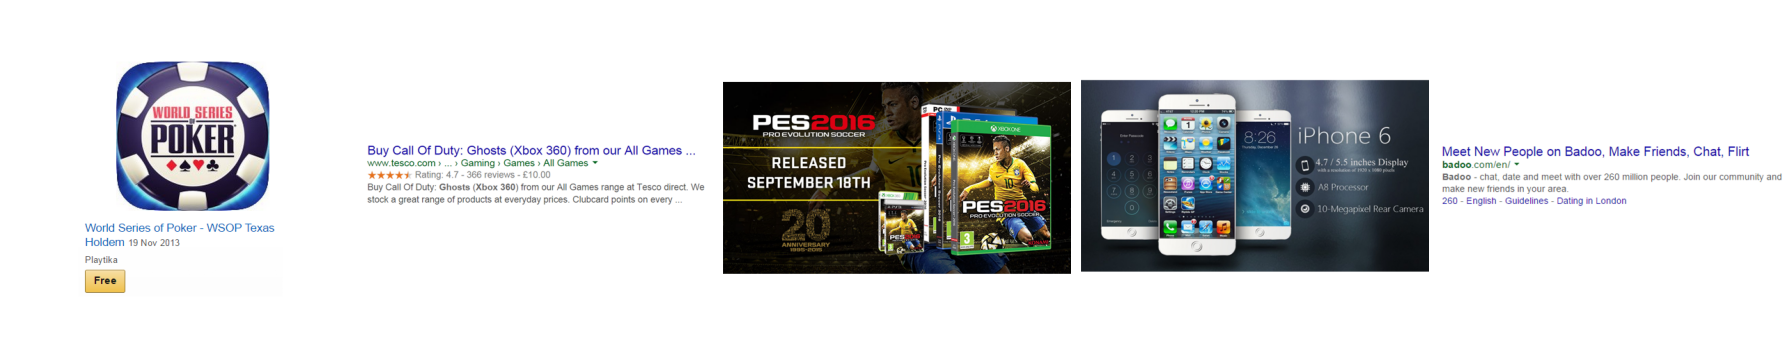

Do not recommend User


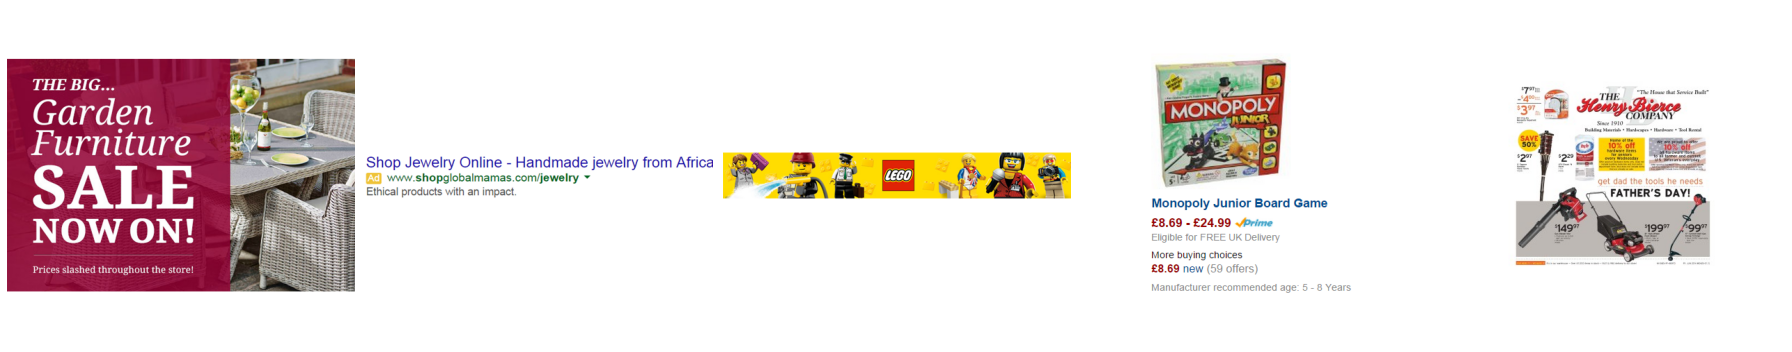

In [ ]:
test(args, np.expand_dims(one_hot_user_info[0,:], axis=0))

early_fusion_lr_1e-2_bs_64.pth
total number of raw images:  300
Test accuracy:0.81000
F1 score:0.89503
Recommend User


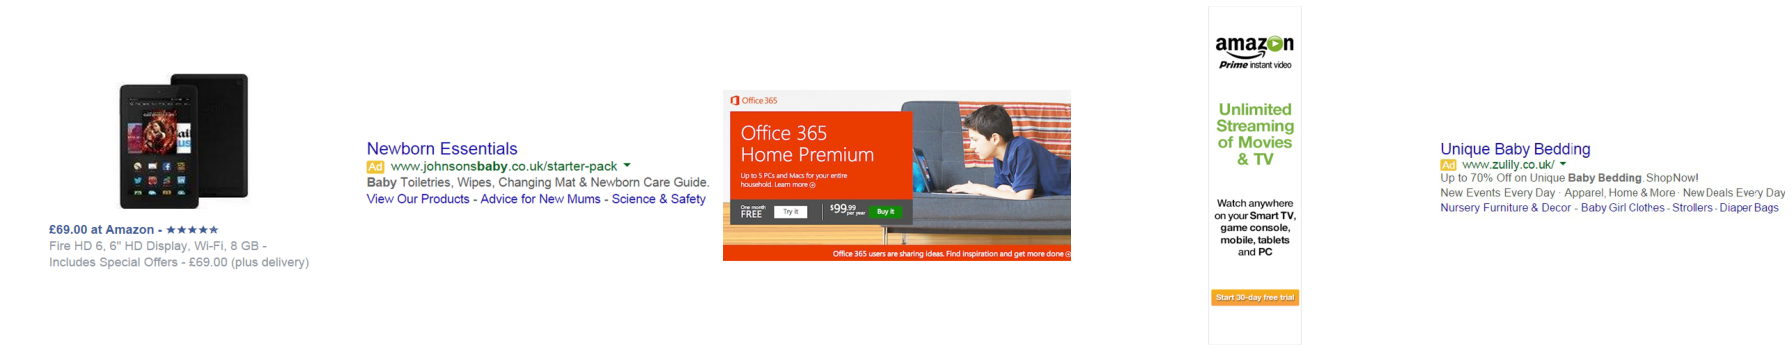

Do not recommend User


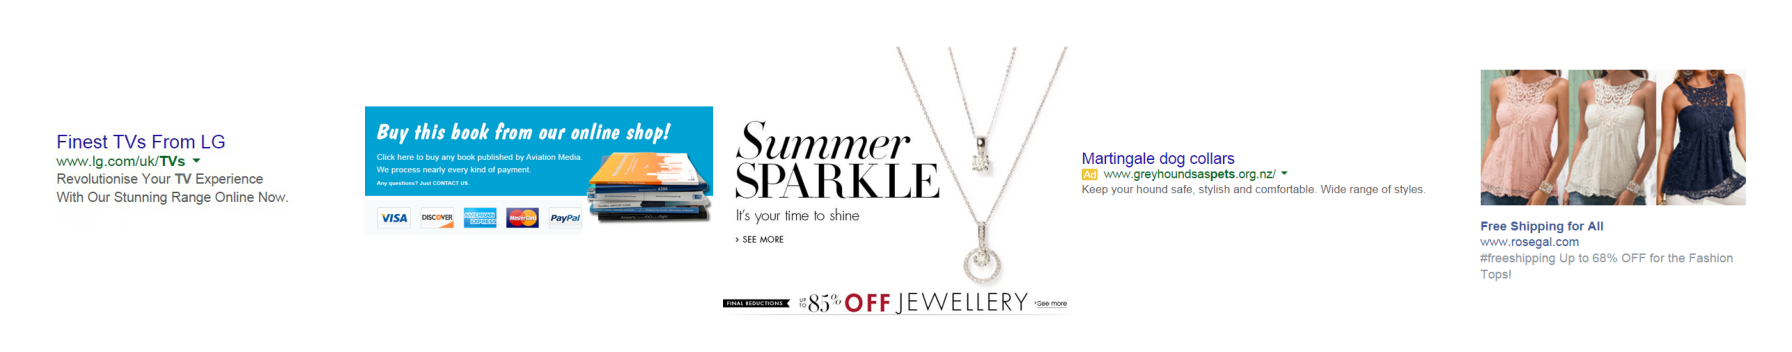

In [ ]:
test(args, np.expand_dims(one_hot_user_info[1,:], axis=0))

early_fusion_lr_1e-2_bs_64.pth
total number of raw images:  300
Test accuracy:0.91333
F1 score:0.95470
Recommend User


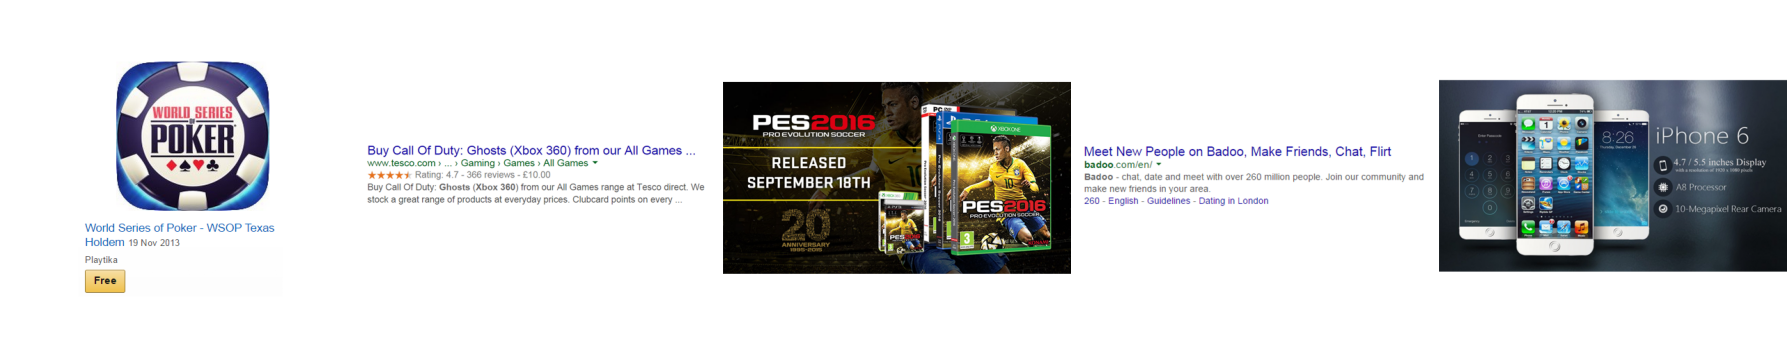

Do not recommend User


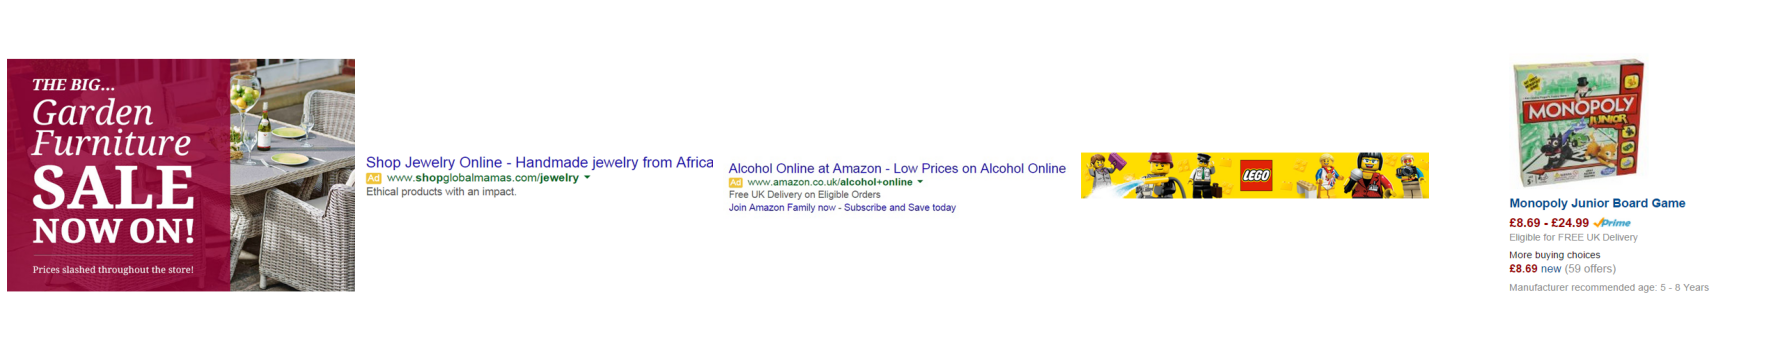

In [ ]:
test(args, np.expand_dims(one_hot_user_info[2,:], axis=0))

early_fusion_lr_1e-2_bs_64.pth
total number of raw images:  300
Test accuracy:0.94000
F1 score:0.96907
Recommend User


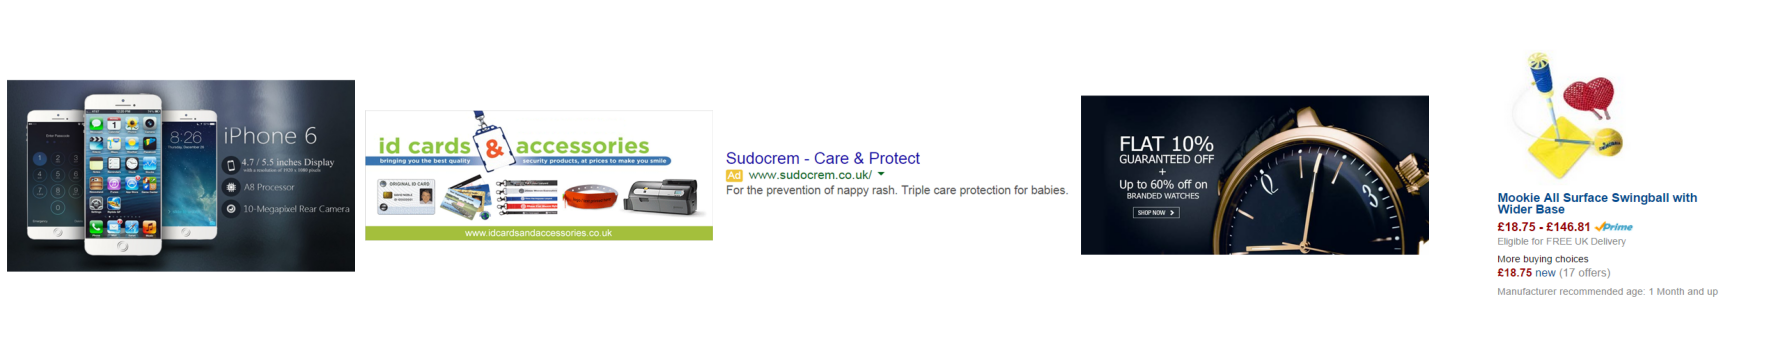

Do not recommend User


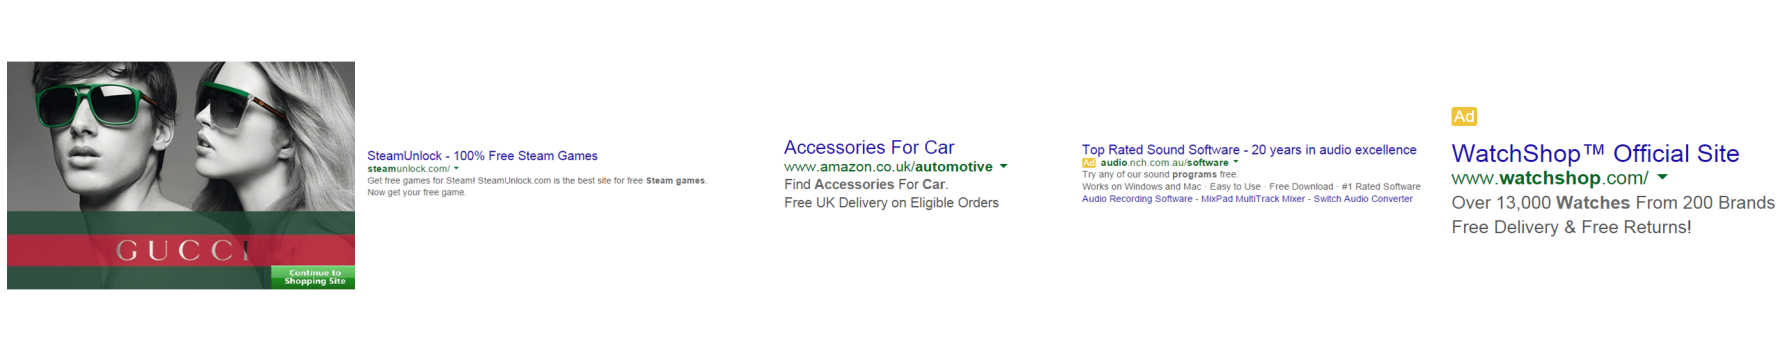

In [ ]:
test(args, np.expand_dims(one_hot_user_info[3,:], axis=0))

Or test it with an existing user in the dataset

early_fusion_lr_1e-2_bs_64.pth
total number of raw images:  300
Test accuracy:0.93000
F1 score:0.96373
Recommend User


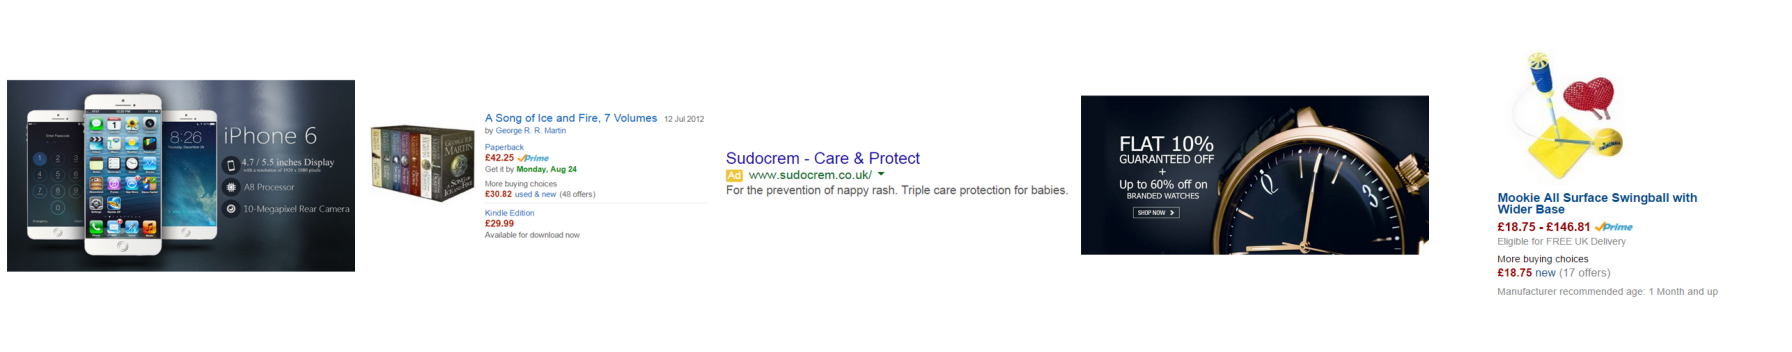

Do not recommend User


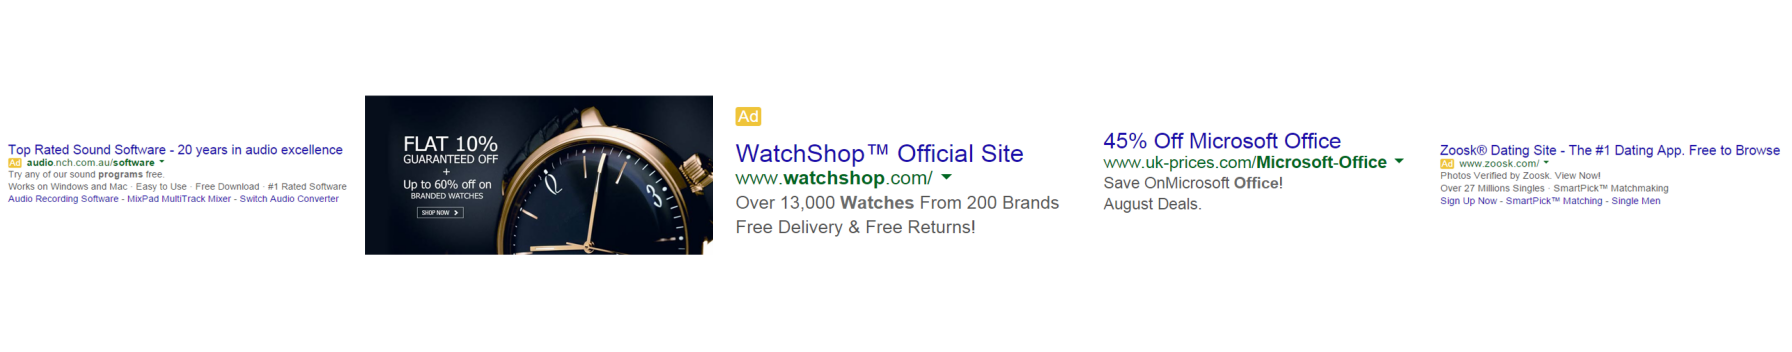

In [ ]:
features_df = pd.read_csv(user_feature_path).to_numpy()
features_df = features_df[:, 3:]
idx = np.random.choice(list(range(2000)), 1)
test(args, features_df[idx,:])